# 1. Load Data

In [1]:

import pandas as pd

df = pd.read_excel('Online Retail.xlsx', sheet_name='Online Retail')


In [2]:
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


# 2. Date Clean-Up

# ignore negative quantity

In [3]:
df = df.loc[df['Quantity'] > 0]

# remove records with NA

In [4]:

df = df[pd.notnull(df['CustomerID'])]

# excluding incomplete month

In [5]:

df = df.loc[df['InvoiceDate'] < '2011-12-01']

# total sales

In [6]:

df['Sales'] = df['Quantity'] * df['UnitPrice']

# per customer data

In [7]:

customer_df = df.groupby('CustomerID').agg({ 'Sales': sum,
'InvoiceNo': lambda x: x.nunique()
})

customer_df.columns = ['TotalSales', 'OrderCount']
 
customer_df['AvgOrderValue'] = customer_df['TotalSales']/customer_df['OrderCount']


In [8]:
customer_df.head(20)

,TotalSales,OrderCount,AvgOrderValue
CustomerID,,,
12346.0,77183.60,1,77183.600000
12347.0,4085.18,6,680.863333
12348.0,1797.24,4,449.310000
12349.0,1757.55,1,1757.550000
12350.0,334.40,1,334.400000
12352.0,2506.04,8,313.255000
12353.0,89.00,1,89.000000
12354.0,1079.40,1,1079.400000
12355.0,459.40,1,459.400000


# check for normalization - mean of 0 & std of 1

In [9]:

rank_df = customer_df.rank(method='first')

In [10]:
rank_df.head(18)

,TotalSales,OrderCount,AvgOrderValue
CustomerID,,,
12346.0,4290.0,1.0,4298.0
12347.0,3958.0,3470.0,3888.0
12348.0,3350.0,2861.0,3303.0
12349.0,3321.0,2.0,4238.0
12350.0,1241.0,3.0,2561.0
12352.0,3630.0,3774.0,2360.0
12353.0,119.0,4.0,201.0
12354.0,2781.0,5.0,4151.0
12355.0,1670.0,6.0,3354.0


In [11]:
normalized_df = (rank_df - rank_df.mean()) / rank_df.std()

In [12]:
normalized_df.head(18)

,TotalSales,OrderCount,AvgOrderValue
CustomerID,,,
12346.0,1.724999,-1.731446,1.731446
12347.0,1.457445,1.064173,1.401033
12348.0,0.967466,0.573388,0.929590
12349.0,0.944096,-1.730641,1.683093
12350.0,-0.732148,-1.729835,0.331622
12352.0,1.193114,1.309162,0.169639
12353.0,-1.636352,-1.729029,-1.570269
12354.0,0.508917,-1.728223,1.612981
12355.0,-0.386422,-1.727417,0.970690


In [13]:
normalized_df.describe()

,TotalSales,OrderCount,AvgOrderValue
count,4298.000000,4298.000000,4.298000e+03
mean,0.000000,0.000000,-6.612776e-18
std,1.000000,1.000000,1.000000e+00
min,-1.731446,-1.731446,-1.731446e+00
25%,-0.865723,-0.865723,-8.657232e-01
50%,0.000000,0.000000,0.000000e+00
75%,0.865723,0.865723,8.657232e-01
max,1.731446,1.731446,1.731446e+00


#3. Customer Segmentation via K-Means Clustering

In [14]:

from sklearn.cluster import KMeans


# K-Means Clustering

In [15]:

kmeans = KMeans(n_clusters=4).fit(normalized_df[['TotalSales', 'OrderCount', 'AvgOrderValue']])

C:\Users\Acer\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


In [16]:

kmeans.labels_


array([3, 1, 1, ..., 0, 2, 1])

In [17]:
kmeans.cluster_centers_

array([[-1.24710672, -0.79832009, -1.0614356 ],
       [ 1.20623767,  1.00587146,  0.86737285],
       [ 0.21602395,  0.71335285, -0.6427677 ],
       [-0.13271459, -0.85015948,  0.79867829]])

In [18]:
four_cluster_df = normalized_df[['TotalSales', 'OrderCount', 'AvgOrderValue']].copy(deep=True)
four_cluster_df['Cluster'] = kmeans.labels_

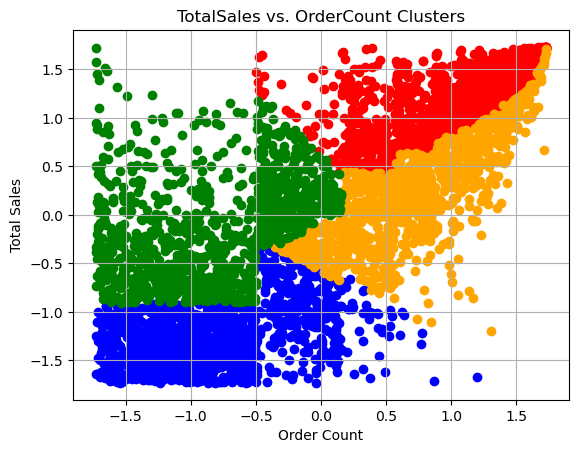

In [19]:
import matplotlib.pyplot as plt
plt.scatter(
four_cluster_df.loc[four_cluster_df['Cluster'] == 0]['OrderCount'], four_cluster_df.loc[four_cluster_df['Cluster'] == 0]['TotalSales'], c='blue'
)

plt.scatter(
four_cluster_df.loc[four_cluster_df['Cluster'] == 1]['OrderCount'], four_cluster_df.loc[four_cluster_df['Cluster'] == 1]['TotalSales'], c='red'
)

plt.scatter(
four_cluster_df.loc[four_cluster_df['Cluster'] == 2]['OrderCount'], four_cluster_df.loc[four_cluster_df['Cluster'] == 2]['TotalSales'], c='orange'
)

plt.scatter(
four_cluster_df.loc[four_cluster_df['Cluster'] == 3]['OrderCount'], four_cluster_df.loc[four_cluster_df['Cluster'] == 3]['TotalSales'], c='green'
)

plt.title('TotalSales vs. OrderCount Clusters') 
plt.xlabel('Order Count')
plt.ylabel('Total Sales')

plt.grid() 
plt.show()


# Selecting the best number of clusters

In [20]:

for n_cluster in [4,5,6,7,8]:
    kmeans = KMeans(n_clusters=n_cluster).fit(
        normalized_df[['TotalSales', 'OrderCount', 'AvgOrderValue']]
    )
    silhouette_avg = silhouette_score(
        normalized_df[['TotalSales', 'OrderCount', 'AvgOrderValue']], 
        kmeans.labels_
    )
    
    print('Silhouette Score for %i Clusters: %0.4f' % (n_cluster, silhouette_avg))

C:\Users\Acer\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


NameError: name 'silhouette_score' is not defined

# Interpreting Customer Segments

In [ ]:

kmeans = KMeans(n_clusters=4).fit(
normalized_df[['TotalSales', 'OrderCount', 'AvgOrderValue']]
)

four_cluster_df = normalized_df[['TotalSales', 'OrderCount', 'AvgOrderValue']].copy(deep=True)
four_cluster_df['Cluster'] = kmeans.labels_


In [ ]:
four_cluster_df.head(16)

In [ ]:
kmeans.cluster_centers_

In [ ]:

high_value_cluster = four_cluster_df.loc[four_cluster_df['Cluster'] == 2] 
pd.DataFrame( 
df.loc[
df['CustomerID'].isin(high_value_cluster.index)
].groupby('Description').count()[ 'StockCode'
].sort_values(ascending=False).head()
)
